
# Deep Convolutional Generative Adversarial Networks

The assignment will help you build the architecture of DC-GAN and learn how to train it from scratch. We will borrow the convolutional architecture that have proven so successful for discriminative computer vision problems and show how they can be leveraged to generate photorealistic images via GANs. And you will learn how to generate facial images and implement it using PyTorch.


## 1 - Packages ##

In [1]:
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as utils
import numpy as np
import matplotlib.pyplot as plt
import time

## 2 - Set training parameters ##

You can choose either setting according to the GPU availability:
1. Full-size training using GPU: number of training images= 10000, batch_size = 128 (~20  minutes on Nvidia RTX2080Ti with 11G memory)
2. Half-size training using CPU: number of training images= 5000,  batch_size = 64  (~8.5 hours   on MacBook with 8G memory)

In [12]:
# Fix the random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Root directory for dataset.
dataroot = "/content/drive/MyDrive/celeba_sm"

# Number of workers for dataloader.
workers = 4

# Batch size during training. You can reduce it if the memory of your CPU/GPU is not large enough.
batch_size = 128

# Spatial size of training images.
# You can reduce it if the training is too slow, and delete several middle layers in both Generator and Discriminator.
image_size = 64

# The size of generator input.
nz = 100

# The number of filters in Generator and Discriminator. You can reduce it if the training is too slow.
ngf = 64

# Number of training epochs. You can reduce it if the training is too slow.
num_epochs = 30

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1, beta2 = 0.5, 0.999

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3 - Face dataset ##

We will use the `Celeb-A Faces dataset` <http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html>, which can
be downloaded at `Files/Datasets/celeba_sm.zip`.

Note that the original dataset contains more that 200,000 images. For efficient training, we can randomly selected about 44k images and crated a smaller version of the dataset for training.

**For Google Colab**: After downloading the zip file, upload it to Google Colab and unzip it by running ``!unzip celeba_sm.zip`` in a notebook cell. Since the zip file is around 300MB, uploading it may take a while!

**For local machine**: Simply unzip it.

In order to efficiently organize the training data, we use `ImageFolder` and `transforms` to build the `DataLoader`.
There are four steps in `transforms`:

- Resize images to (image_size, image_size).
- CenterCrop images to (image_size, image_size).
- Convert images to tensors.
- Normalize images (the mean and std of each channel are both 0.5).

You can also add other transformations such as `RandomCrop`, `flip` or `rotation` for data augmentation.

In [ ]:
import zipfile
import os

# Path to your .zip file in Google Drive
zip_path = '/content/drive/MyDrive/celeba_sm.zip'

# Destination folder where contents will be extracted
extract_to = '/content/drive/MyDrive'

# Create the directory if it does not exist
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print('Files extracted.')

In [13]:
# Create the dataset
dataset = torchvision.datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               ### START CODE HERE ### (≈ 4 lines of code)
                              transforms.Resize(image_size),
                              transforms.CenterCrop((image_size, image_size)),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ### END CODE HERE ###
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


You can visualize some examples by running the following code.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


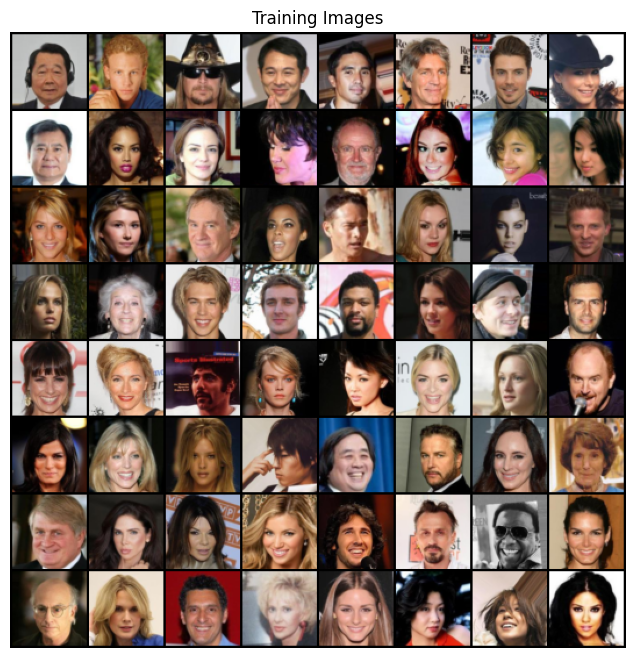

In [14]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## 4 - Weight initialization ##

From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The ``weights_init`` function takes an initialized model as
input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.

In [15]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        ### START CODE HERE ### (≈ 1 lines of code)
        m.weight.data.normal_(0.0, 0.02)
        ### END CODE HERE ###
    elif classname.find('BatchNorm') != -1:
        ### START CODE HERE ### (≈ 1 lines of code)
        m.weight.data.normal_(0.0, 0.02)
        ### END CODE HERE ###
        nn.init.constant_(m.bias.data, 0)

## 5 - Defining the networks ##

The core to the DCGAN architecture uses a standard CNN architecture on the discriminative model. For the generator, convolutions are replaced with upconvolutions, so the representation at each layer of the generator is actually successively larger, as it mapes from a low-dimensional latent vector onto a high-dimensional image.

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).

- Use batch normalization in both the generator and the discriminator.

- Remove fully connected hidden layers for deeper architectures.

- Use ReLU activation in generator for all layers except for the output, which uses Tanh.

- Use LeakyReLU activation in the discriminator for all layers.

The generator, $G$, is designed to map the latent space vector ($z$) to data-space. Since our data are images, converting $z$ to data-space means ultimately creating a RGB image with the same size as the training images (i.e. $3 \times 64 \times 64$).

There are 5 convolutional transpose layers in  $G$:

- For all the layers, the size of the convolutional filter is 4x4. The numbers of filters are $\{\text{ngf} \times 8, \text{ngf} \times 4, \text{ngf} \times 2, \text{ngf}, 3\}$. The strides are $\{1, 2, 2, 2, 2\}$. The paddings are $\{0, 1, 1, 1, 1\}$.

- For the first 4 layers, each is paired with a 2d BatchNorm2d layer and a ReLU activation.

- For the last layer, it is followed by a tanh function to return it to the input data range of $[-1,1]$.


In [17]:
# Definition of Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            #  output size: (ngf*8) x 4 x 4

            ### START CODE HERE ### (≈ 11 lines of code)
            nn.ConvTranspose2d((ngf*8), ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            #  output size: (ngf*4) x 8 x 8

            nn.ConvTranspose2d((ngf*4), ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            #  output size: (ngf*2) x 16 x 16

            nn.ConvTranspose2d((ngf*2), ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            #  output size: ngf x 32 x 32

            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            #  output size: 3 x 64 x 64
            ### END CODE HERE ###
        )

    def forward(self, input):
        return self.layers(input)

In [18]:
netG = Generator()
# fixed_noise = torch.randn([128, 64])
fixed_noise = torch.randn(64, nz, 1, 1)
print(fixed_noise.shape)
img = netG(fixed_noise).detach()[0].permute(1,2,0)

torch.Size([64, 100, 1, 1])


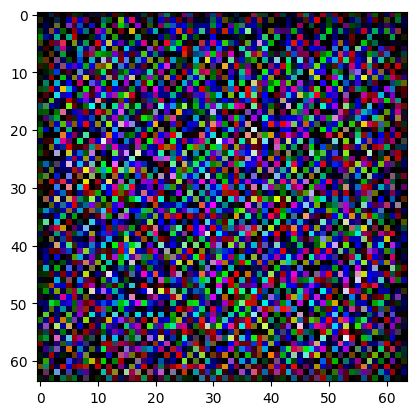

In [19]:
import matplotlib.pyplot as plt
plt.imshow(img)

The discriminator, $D$, is a binary classification network that takes an image as input and outputs a scalar probability that the input image is real (as opposed to fake). Here, $D$ takes a $3 \times 64 \times 64$ input image, processes it through a series of Conv2d, BatchNorm2d, and LeakyReLU layers, and outputs the final probability through a Sigmoid activation function. This architecture can be extended with more layers if necessary for the problem, but there is significance to the use of the strided convolution, BatchNorm, and LeakyReLUs.

There are 5 convolutional layers in $D$:

- The architecture is: Conv2d,LeakyReLU→Conv2d,BatchNorm2d,LeakyReLU→Conv2d,BatchNorm2d,LeakyReLU→Conv2d,BatchNorm2d,LeakyReLU→Conv2d,Sigmoid. The size of the convolutional filter is $4 \times 4$. The numbers of filters are $\{\text{ngf}, \text{ngf} \times 2, \text{ngf} \times 4, \text{ngf} \times 8, 1\}$. The strides are $\{2, 2, 2, 2, 1\}$. The paddings are $\{1, 1, 1, 1, 0\}$.

- The slope of all LeakyReLU is 0.2.

In [20]:
# Definition of Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, ngf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # output size: 64 x 32 x 32

            ### START CODE HERE ### (≈ 11 lines of code)
            nn.Conv2d(ngf, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # output size: (ngf*2) x 16 x 16

            nn.Conv2d(ngf*2, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # # output size: (ngf*4) x 8 x 8

            nn.Conv2d(ngf*4, ngf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # # output size: (ngf*8) x 4 x 4

            nn.Conv2d(ngf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # ### END CODE HERE ###


        )

    def forward(self, input):
        return self.layers(input)

After the definition of $G$ and $D$, we can apply the ``weights_init`` function, and print the model’s structure.

In [21]:
# Create the generator and Discriminator
netG = Generator().to(device)
netD = Discriminator().to(device)

### START CODE HERE ### (≈ 2 lines of code)
# Apply the weights_init function to randomly initialize all weights
weights_init(netG)
weights_init(netD)
### END CODE HERE ###

# Print the model
print(netG)
print(netD)

Generator(
  (layers): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )


## 6 - Loss Functions and Optimizers ##

With $D$ and $G$ setup, we can specify how they learn through the loss functions and optimizers. We will use the Binary Cross Entropy loss which is defined in PyTorch as:

\begin{align}\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\end{align}

Notice how this function provides the calculation of both log components in the objective function (i.e. $log(D(x))$ and $log(1-D(G(z)))$). We can specify what part of the BCE equation to use with the $y$ input. This is accomplished in the training loop which is coming up soon, but it is important to understand how we can choose which component we wish to calculate just by changing $y$ (i.e. GT labels).

Next, we define our real label as 1 and the fake label as 0. These labels will be used when calculating the losses of $D$ and $G$, and this is also the convention used in the original GAN paper. Finally, we set up two separate optimizers, one for $D$ and one for $G$. As specified in the DC-GAN paper, both are Adam optimizers with learning rate 0.0002 and Beta1 = 0.5.

In [22]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))

## 7 -  Training the networks ##

Finally, now that we have all of the parts of the GAN framework defined, we can train it.  Training is split up into two main parts. Part 1 updates the Discriminator and Part 2 updates the Generator.

**Part 1 - Train the Discriminator**

Recall, the goal of training the discriminator is to maximize the probability of correctly classifying a given input as real or fake. In terms of Goodfellow, we wish to “update the discriminator by ascending its stochastic gradient”. Practically, we want to maximize $log(D(x)) + log(1-D(G(z)))$. Due to the separate mini-batch suggestion from ganhacks, we will calculate this in two steps:

- First, we will construct a batch of real samples from the training set, forward pass through $D$, calculate the loss ($log(D(x))$), then calculate the gradients in a backward pass.
- Secondly, we will construct a batch of fake samples with the current generator, forward pass this batch through $D$, calculate the loss ($log(1-D(G(z)))$), and *accumulate* the gradients with a backward pass. Now, with the gradients accumulated from both the all-real and all-fake batches, we call a step of the Discriminator’s optimizer.

**Part 2 - Train the Generator**

As stated in the original paper, we want to train the Generator by minimizing $log(1-D(G(z)))$ in an effort to generate better fakes. As mentioned, this was shown by Goodfellow to not provide sufficient gradients, especially early in the learning process. As a fix, we instead wish to maximize $log(D(G(z)))$. In the code we accomplish
this by: classifying the Generator output from Part 1 with the Discriminator, computing G’s loss *using real labels as GT*, computing G’s gradients in a backward pass, and finally updating G’s parameters with an optimizer step. It may seem counter-intuitive to use the real labels as GT labels for the loss function, but this allows us to use the
$log(x)$ part of the BCELoss (rather than the $log(1-x)$ part) which is exactly what we want.

Finally, we will do some statistic reporting and at the end of each epoch we will push our fixed_noise batch through the generator to visually track the progress of G’s training. The training statistics reported are:

-  **Loss_D** - discriminator loss calculated as the sum of losses for
   the all real and all fake batches ($log(D(x)) + log(D(G(z)))$).
-  **Loss_G** - generator loss calculated as $log(D(G(z)))$
-  **D(x)** - the average output (across the batch) of the discriminator
   for the all real batch. This should start close to 1 then
   theoretically converge to 0.5 when G gets better. Think about why
   this is.
-  **D(G(z))** - average discriminator outputs for the all fake batch.
   The first number is before D is updated and the second number is
   after D is updated. These numbers should start near 0 and converge to
   0.5 as G gets better. Think about why this is.

**Note:** This step might take a while, depending on how many epochs you
run and if you removed some data from the dataset.

In [23]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_img = data[0].to(device)
        b_size = real_img.size(0)
        label = torch.full((b_size,), real_label, device=device)

        ### START CODE HERE ### (≈ 3 lines of code)
        # Forward pass real batch through D
        output = netD(real_img).squeeze()
        # Calculate loss on all-real batch
        errD = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD.backward()
        ### END CODE HERE ###

        D_x = output.mean().item()

        ## Train with all-fake batch

        ### START CODE HERE ### (≈ 2 lines of code)
        # Generate batch of latent vectors
        fixed_noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        img_fake = netG(fixed_noise)
        ### END CODE HERE ###

        label.fill_(fake_label)

        ### START CODE HERE ### (≈ 3 lines of code)
        # Classify all fake batch with D
        output = netD(img_fake).squeeze()
        # Calculate D's loss on the all-fake batch
        errG = criterion(output, label)
        # Calculate the gradients for this batch
        errG.backward(retain_graph=True)
        ### END CODE HERE ###

        D_G_z1 = output.mean().item()

        ### START CODE HERE ### (≈ 2 lines of code)
        # Add the gradients from the all-real and all-fake batches
        sum_loss = errD + errG
        # Update D
        optimizerD.step()
        ### END CODE HERE ###

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost

        ### START CODE HERE ### (≈ 3 lines of code)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(img_fake).squeeze()
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        ### END CODE HERE ###

        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/30][0/347]	Loss_D: 0.6528	Loss_G: 2.6577	D(x): 0.5281	D(G(z)): 0.4654 / 0.0735
[0/30][50/347]	Loss_D: 0.0081	Loss_G: 12.6467	D(x): 0.9939	D(G(z)): 0.0000 / 0.0000
[0/30][100/347]	Loss_D: 1.0620	Loss_G: 3.6798	D(x): 0.4822	D(G(z)): 0.0282 / 0.0702
[0/30][150/347]	Loss_D: 0.1569	Loss_G: 3.8797	D(x): 0.8653	D(G(z)): 0.5996 / 0.0329
[0/30][200/347]	Loss_D: 0.3654	Loss_G: 3.0372	D(x): 0.7191	D(G(z)): 0.3230 / 0.0608
[0/30][250/347]	Loss_D: 0.5571	Loss_G: 1.9931	D(x): 0.6154	D(G(z)): 0.1949 / 0.1582
[0/30][300/347]	Loss_D: 2.7791	Loss_G: 1.2841	D(x): 0.1150	D(G(z)): 0.0086 / 0.3498
[1/30][0/347]	Loss_D: 0.4722	Loss_G: 2.1698	D(x): 0.6575	D(G(z)): 0.2423 / 0.1400
[1/30][50/347]	Loss_D: 1.0231	Loss_G: 2.3085	D(x): 0.4277	D(G(z)): 0.0327 / 0.1336
[1/30][100/347]	Loss_D: 0.1155	Loss_G: 3.9281	D(x): 0.9020	D(G(z)): 0.5279 / 0.0305
[1/30][150/347]	Loss_D: 0.3994	Loss_G: 3.2320	D(x): 0.7088	D(G(z)): 0.3056 / 0.0548
[1/30][200/347]	Loss_D: 0.7880	Loss_G: 2.5596	D(x): 0.5

## 8 -  Results ##

Finally, lets check out how we did. Here, we will look at two different results. First, we will see how D and G’s losses changed during training. Second, we will compare a batch of real data and a batch of fake data from G.

You can use the following code to visualize D & G’s losses versus training iterations.

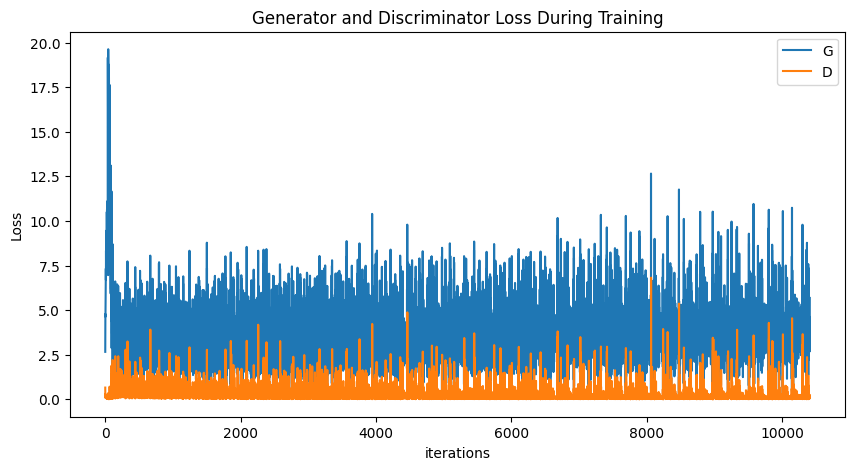

In [24]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Finally, lets take a look at some real images and fake images side by side.

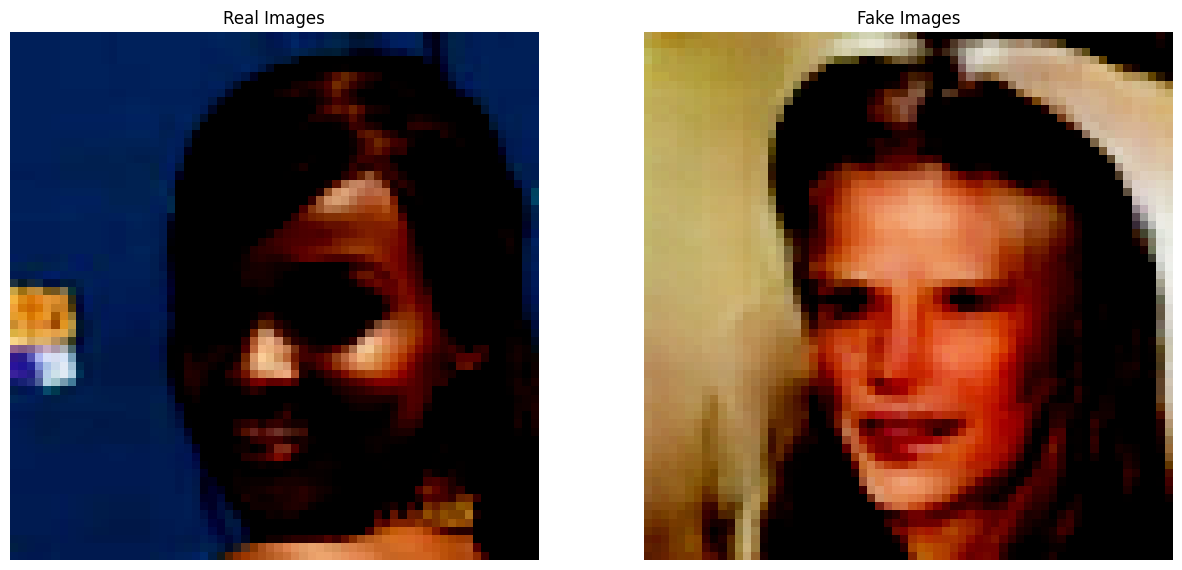

In [25]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")

### START CODE HERE ### (≈ 1 lines of code)
plt.imshow(real_batch[0][0].permute(1,2,0))
### END CODE HERE ###

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")

### START CODE HERE ### (≈ 1 lines of code)
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
img = netG(fixed_noise).cpu().detach()[0].permute(1,2,0)
plt.imshow(img)
### END CODE HERE ###

plt.show()

## 9 - Conditional GAN (optional) ##

Congratulations on finishing this assignment. Now you can generate various facial images with your DC-GAN. However, the attributes (e.g., hair color, facial expressions, etc) of generated faces are not controllable. To achieve this, you can design an Encoder to extract features, and use them to feed the Generator to see whether the Generator can reconstruct the input images. Note that the architecture of Encoder can be viewed as the reverse of Generator.

For more details, please refer to https://arxiv.org/pdf/1512.09300.pdf.